<a href="https://colab.research.google.com/github/WandsOliveira/LVA/blob/main/Exercise_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center"">
  <h1>Universidade Estadual de Campinas</h1>
  <h2>Faculdade de Engenharia Mecânica</h2>
  <h2>Departamento de Mecânica Computacional</h2>
  <h2>Laboratório de Vibro-Acústica</h2>
  <p>Autor: Wanderson Vinicius de O. Monteiro</p>
</div>

---

## Análise da propagação de ondas longitudinais em uma barra uniforme e uma barra períodica, utilizando os métodos de propagação de ondas e  superposição modal.


In [125]:
# Import de bibliotecas
import numpy as np                        # Biblioteca numérica
import matplotlib.pyplot as plt           # Biblioteca gráfica

In [126]:
# Dados do material e Geometria
L = 1            # Comprimento da Barra                           [m]
E = 210e09       # Módulo de Elasticidade                         [Pa]
rho = 7800       # Densidade                                      [kg / m^3]
A = 0.015 ** 2   # Área da seção transversal                      [m^2]

O pulso incidente no início da barra escolhido foi modelado como uma função exponencial com a seguinte equação:

$$ P(t) = \exp(-5 \cdot t)  \hspace{.5 cm} (1.0) $$

Nesta equação, o fator de multiplicação \(5\) é utilizado para controlar a taxa de decaimento do pulso, permitindo que ele decaia mais rapidamente em direção a zero com o aumento de \(t\).


In [127]:
# Dados da força, tempo e frequência
N = 4096                                                      # Número de pontos          [-]
T = 0.06                                                      # Período                   [s]
tt = np.arange(0, 1, 0.001)                                   # Duracao do pulso          [s]
F = np.exp(-5 * tt)                                           # Pulso exponencial (Eq. 01)[N]
F = np.concatenate((F, np.zeros(N - len(F))))                 # Complemento do pulso      [N]
dt = T / N                                                    # Discretização tempo       [s]
t = np.arange(0, T, dt)                                       # Vetor tempo               [s]
df = 1/T                                                      # Discretização frequência  [Hz]
frequencia = np.arange(0, int(N/2)* df, df)                   # Vetor Frequência          [Hz]
omega = 2 * np.pi * frequencia                                # Frequência angular        [rad^-1]

Text(0, 0.5, 'Pulso [N]')

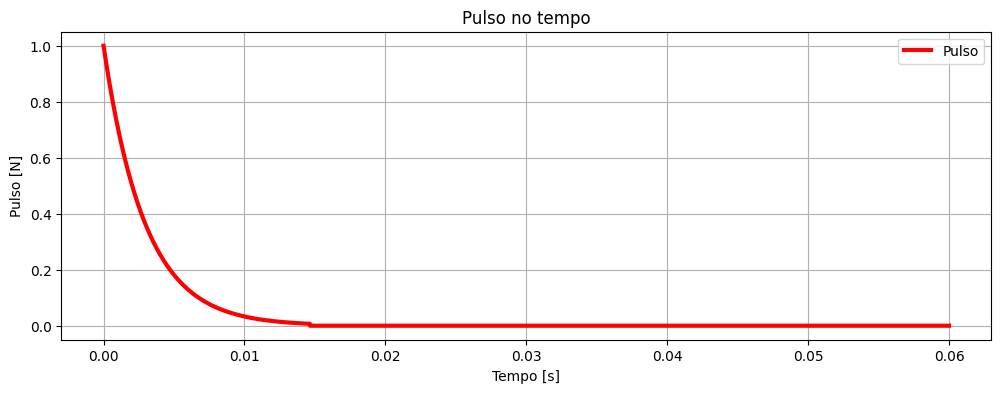

In [128]:
# Plot do pulso no tempo
plt.figure( figsize = (12,4))
plt.plot(t, F, color = 'red', linestyle = '-', label = 'Pulso', linewidth = 3 )
plt.grid(True)
plt.legend()
plt.title("Pulso no tempo")
plt.xlabel("Tempo [s]")
plt.ylabel('Pulso [N]')

Text(0, 0.5, 'Pulso [N]')

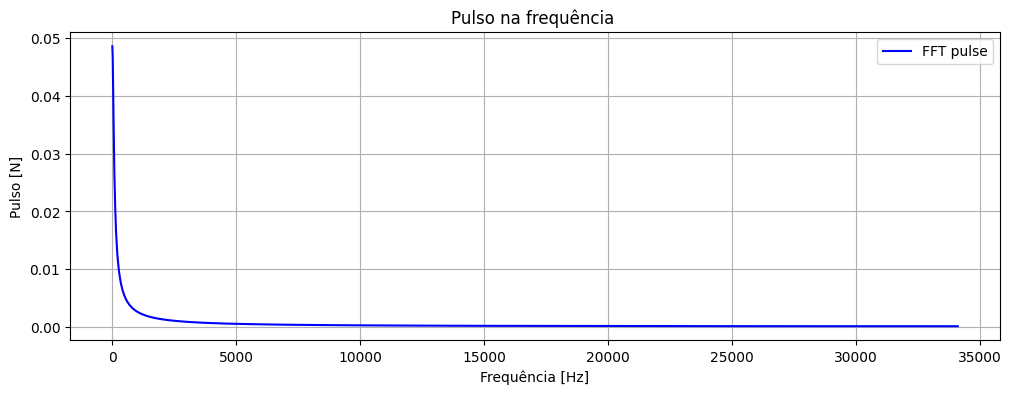

In [129]:
# Plot do pulso na frequência
Fw = (1/ N ) * np.fft.fft(F)     # Transformada de Fourier no  pulso
plt.figure( figsize = (12,4))
plt.plot(frequencia, abs(Fw[:int(N//2)]), color = 'blue', linestyle = '-', label = 'FFT pulse' )
plt.grid(True)
plt.legend()
plt.title("Pulso na frequência ")
plt.xlabel("Frequência [Hz]")
plt.ylabel('Pulso [N]')

# Wave Propagation

## A análise através da propagação de ondas é conduzida mediante a superposição das reflexões da onda em um ponto específico da estrutura. Isso implica na investigação da propagação da onda tanto se propagando para direita   (forward) quanto para esquerda (backward).

In [130]:
# Ponto de medição, velocidade e número de onda
x = L/2                      # Medição no centro da barra       [m]
qsi = 0.025                  # Amortecimento estrutural         [-]
Ea = E * (1 + 1j* 2 * qsi)   # Modulo de elasticidade complexo  [Pa]
c = np.sqrt(Ea/rho)          # Velocidade do som                [m/s]
k = omega / c                # Número de onda                   [m^-1]

## Assumindo a onda se propagando para direita, temos que a solução da primeira onda propagante se da pela forma:

$$ EA\left[ -ik_1\mathbf{A}(\omega)\right] = - F(\omega)  \Rightarrow  \mathbf{A}(\omega) = \frac{F(ω)}{ik_1EA} \hspace{.5 cm} (2.0) $$

Onde,
- A Onda se deslocando para direita;
- E é o módulo de elásticidade;
- A Área da seção transversal;
- k o número de onda;
- F o pulso.

In [131]:
Go = np.zeros(int(N/2) , dtype = complex)                      # Alocação de memória
Go[1:int(N/2)] = 1 / (1j * k[1:int(N/2) ] * Ea * A)            # Onda se deslocando para direita (Eq. 02)

# A solução completa da onda se propagando para direita é, portanto:

$$  u(x,t) = \sum_\omega \frac{F(\omega)}{ik_1EA} \exp(-i(k_1x - \omega t)) \hspace{.5 cm} (3.0)$$

Passando para  o domínio da frequência:
$$\hat{u}(x,\omega) = G(x,\omega)F(\omega) \hspace{.5 cm} (4.0) $$ ,

Onde:

$$ G(x, \omega) = \frac{e^{-ik_1x}}{ik_1EA} \hspace{.5 cm} (5.0)$$


In [132]:
# Primeira frente de onda
Gp = Go * np.exp(-1j * k * x)
# Número de Reflexões
nr = 150
# Propagação de onda
U_R = Go * np.exp(- 1j * k * L)
for i in range(1,nr +1):
  Gp = Gp + U_R * np.exp(- 1j * k * (L - x))
  U_L = U_R * np.exp( -1j * k * L)
  Gp = Gp + U_L* np.exp(- 1j * k * x)
  U_R = U_L * np.exp(-1j * k * L)
Gp[0] = Gp[1]

## Por fim,  a aceleração pode ser calculada por:

$$  U_{ap} = -\omega^2 \cdot G(x,\omega) \cdot F(\omega)\hspace{.5 cm} (6.0)$$

In [133]:
Uap = np.zeros(N, dtype = complex)
Uap[: int(N / 2)] = -omega[:int(N / 2)] ** 2 * Fw[:int(N / 2)] * Gp
Uap[int(N/2) +1] = 0
Uap[int(N/2) + 2 :] = ((np.conj(np.flip(Uap[0:int(N / 2 - 2)]))))

## Utilizando a transformada inversa de Fourier, obtemos a resposta da aceleração no tempo.

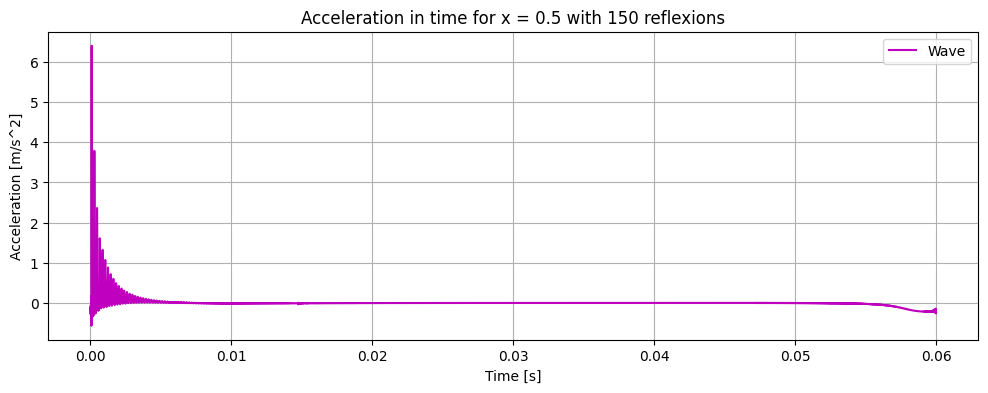

In [134]:
up = np.real(N *  np.fft.ifft(Uap))
plt.figure(figsize = (12, 4))
plt.plot(t, up, label = 'Wave', linestyle = '-', color = 'm')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.title(f'Acceleration in time for x = {x} with {nr} reflexions')
plt.grid(True)
plt.legend()


# Modal solution

Partindo da solução homogênea, da forma:

$$ EA \frac{d^2\hat{u}}{dx^2} + \omega^2 \rho A \hat{u} = 0 \hspace{.5 cm} (7.0)$$

fazendo $ \lambda = \omega\sqrt{\frac{\rho A}{EA}}$, temos:

$$ \frac{d^2\hat{u}}{dx^2}d + \lambda^2 \hat{u} = 0 \hspace{.5 cm} (8.0)$$

A solução da Equação 8.0 pode ser da forma:

$$ \hat{u} = A_1\cos(\lambda x) + A_2\sin(\lambda x)\hspace{.5 cm} (9.0)$$


Derivando a Equação (9.0) em relação ao espaço, temos:

$$ \frac{d\hat{u}}{dx} = -\lambda A_1\sin(\lambda x) + \lambda A_2 \cos(\lambda x) \hspace{.5 cm} (10.0) $$

Aplicando as condições de contorno livre - livre :
- $\frac{d\hat{u}}{dx} \Bigg|_{x=0} = 0$
- $\frac{d\hat{u}}{dx} \Bigg|_{x=L} = 0$

Das condições de contorno, para $x = 0$ temos $A_2 = 0$ e para condição de contorno em $ x = L$, temos:

$$ -\lambda A_1 \sin(\lambda L) = 0 ⇒ \lambda = 0 \ \text{ou} \ \sin(\lambda L) = 0 ⇒ \lambda L = 0, \pi, 2\pi, 3\pi, \cdots  \hspace{.5 cm} (11.0) $$

Retornando para equação de $\lambda$, temos:

$$ \omega_n = \lambda_n \sqrt{\left(\frac{EA}{\rho A}\right)}
 ,\ \ n = 1,2,3, \cdots  \hspace{.5 cm} (12.0)$$

 Em que cada $n$ corresponde a uma solução do tipo :

 $$ \hat{u}(x, \omega_n) = \hat{U}_n \phi_n(x)   \hspace{.5 cm} (13.0)$$

 onde:

 $$ \phi_n(x) = \cos\left(\frac{n\pi x}{L}\right)
\hspace{.5 cm} (14.0)$$

Através da formulação, pode-se obter também a matriz de massa e rigidez modal, da forma:

$$ M_r = \int_0^L \rho A \cos^2\left(\frac{r\pi x}{L} \right)dx = \frac{\rho A L}{2} \hspace{.5 cm} (15.0)$$

$$ K_r = \int_0^L E A \sin^2\left(\frac{r\pi x}{L} \right)dx = \frac{E A}{2L}(r\pi)^2 \hspace{.5 cm} (16.0)$$

In [135]:
m = 30   # Número de modos
Phi = np.zeros(m, dtype = complex)  # Alocação de memória
M = np.zeros(m, dtype = complex)    # Alocação de memória
K = np.zeros(m, dtype = complex)    # Alocação de memória

In [136]:
for r in range(1, m +1):
  Phi[r-1] = np.cos( r * np.pi * x/L)                  # Phi
  M[r-1] = rho*A*L/2                                  # Matriz de massa modal
  K[r-1] = (E * A / (2 * L)) * (r * np.pi) ** 2        # Matriz de rigidez modal

A $FRF$ em determinado ponto $x$ pode ser obtida pela soma das soluções modais:

$$\hat{G}(\omega) = \sum_{r = 1}^{\infty}  \frac{\phi_r(x)\phi_r(0)}{K_r - M_r\omega^2}\hspace{.5 cm} (17.0) $$

In [137]:
G = np.zeros(int(N / 2), dtype = complex)
G[1: int(N/2)] = -1 / (omega[1: int(N/2)] ** 2 * rho * A* L) # rigidez
for i in range(1, int(N/ 2) +1):
  for r in range(1, r + 1):
      wr = np.sqrt(K[r-1] /M[r-1])
      G[i-1] = G[i-1] + Phi[r-1]/(M[r-1] * (wr ** 2 - omega[i-1] ** 2 + 1j * 2 * qsi * omega[i-1] * wr))


In [138]:
U = np.zeros(N, dtype = complex)
U[:int(N/2) ] = G * Fw[: int(N/2)]
U[:int(N/2) ]  = - omega ** 2 * U[:int(N/2) ]   # Aceleração modal
U[int(N/2) +1] = 0
U[int(N/2) + 2 :] = ((np.conj(np.flip(U[0:int(N/2) - 2]))))

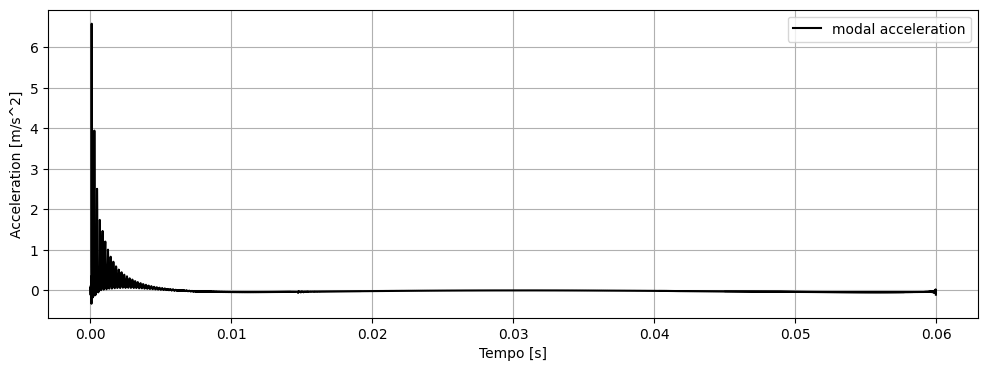

In [139]:
u = np.real( N * np.fft.ifft(U))
plt.figure(figsize = (12,4))
plt.plot(t,u, label = 'modal acceleration', linestyle = '-', color = 'k')
plt.xlabel('Tempo [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.grid(True)
plt.legend()

# Comparações entre os métodos

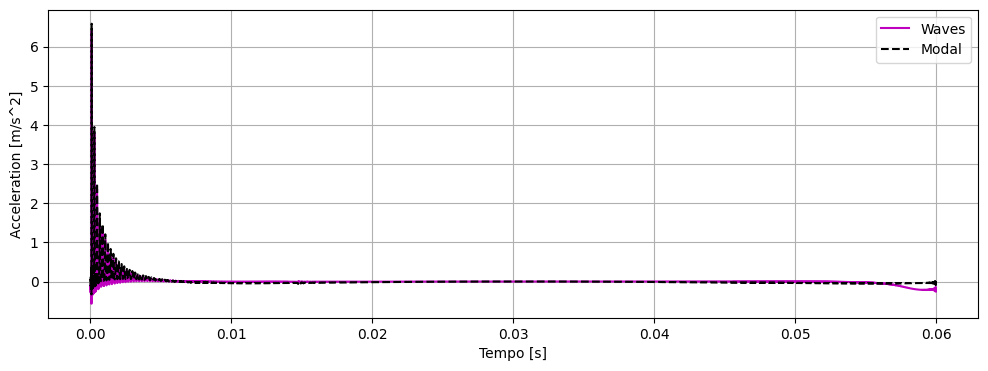

In [140]:
plt.figure(figsize = (12,4))
plt.plot(t,up, label = 'Waves', linestyle = '-', color = 'm')
plt.plot(t,u, label = 'Modal', linestyle = '--', color = 'k')
plt.xlabel('Tempo [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.grid(True)
plt.legend()

<ipython-input-141-205e22bf2172>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencia, 20 * np.log10(np.abs(U[: int(N/2)]/(Fw[: int(N/2)]))), color = 'blue', linestyle = '-', label = 'Modal FRF ')
<ipython-input-141-205e22bf2172>:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencia, 20 * np.log10(np.abs(Uap[: int(N/2)]/(Fw[: int(N/2)]))), color = 'red', linestyle = '--', label = 'Waves FRF ')


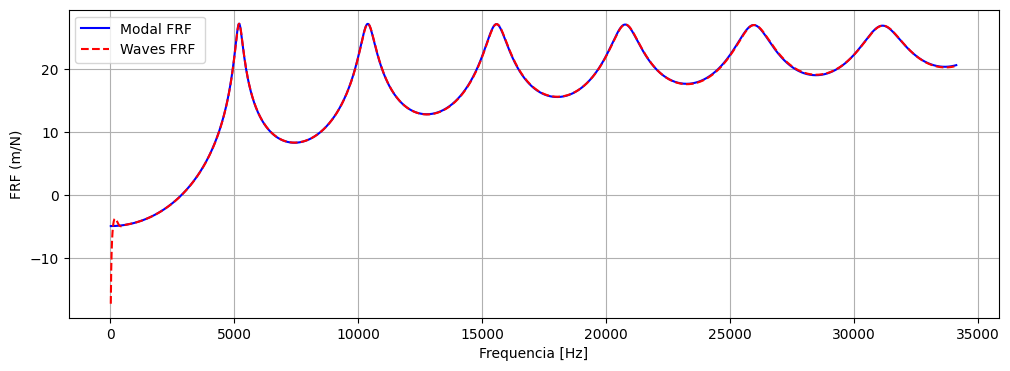

In [141]:
plt.figure(figsize = (12,4))
plt.plot(frequencia, 20 * np.log10(np.abs(U[: int(N/2)]/(Fw[: int(N/2)]))), color = 'blue', linestyle = '-', label = 'Modal FRF ')
plt.plot(frequencia, 20 * np.log10(np.abs(Uap[: int(N/2)]/(Fw[: int(N/2)]))), color = 'red', linestyle = '--', label = 'Waves FRF ')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('FRF (m/N)')
plt.grid(True)
plt.legend()

## Conclusão
Foi realizada um estudo sobre a propagação de ondas em uma barra uniforme, por meio dos métodos de propagação de ondas e superposição modal, no qual os resultados, tanto no domínio do tempo quanto no domínio da frequência, convergiram.

A analíse por porpgação de ondas, foi necessário pelo menos 150 reflexões, para que os resultados para as primeiras frequências se tornassem mais adequados, abaixo de 100 reflexões, estes resultados apresentaram uma alta divergencia com o resultados modal, o que é esperado pelo método.

Para a analíse modal, com poucos modos (abaixo de 10) os resultados entre os métodos foram adequados, para baixas e médias frequências, para frequências acima de 20 KHz, foi necessário aumentar o número de modos para 30 para que ocorrece uma convergencia entre os métdos.